In [1]:
!pip install -r requirements.txt

# Search

### Living Area codes

In [ ]:
location_ids=473422

### Settings

In [ ]:
living_area_max=45
living_area_min=35
rooms_min=1.5

### Build URL

In [2]:
url = 'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=2&rooms_min=1.5'

# Request data from Hemnet

In [3]:
import requests

def load_html(url):
    headers = {
        'User-Agent': 'Your User Agent String'  # Replace with an appropriate User-Agent
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

if __name__ == "__main__":
    url = input("Enter the URL: ")
    #https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=2&rooms_min=1.5
    html_content = load_html(url)

    if html_content:
        print("Successfully lead data from %s" % url)
        # print(html_content)
    else:
        print("Failed to fetch HTML content.")


Successfully lead data from https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=2&rooms_min=1.5


In [24]:
import pandas as pd
from bs4 import BeautifulSoup
import datetime 



month_conv = {
    'januari' : 1,
    'februari' : 2,
    'mars' : 3,
    'april' : 4,
    'maj' : 5,
    'juni' : 6,
    'juli' : 7,
    'augusti' : 8,
    'september' : 9,
    'oktober' : 10,
    'november' : 11,
    'december' : 12
}

def extract_rooms(room_text):
    if "rum" in room_text:
        room_parts = room_text.split(" ")
        for part in room_parts:
            if "rum" in part:
                rooms = part.replace(",", ".").replace("&nbsp;", "").replace("rum", "")
                try:
                    return float(rooms)
                except ValueError:
                    return 0.0
    return 0.0

def extract_date_format(date_str):
    try:
        date_arr = date_str.split(' ')

        day   = int(date_arr[1])
        month = month_conv[date_arr[2]]
        year  = int(date_arr[3])

        date = datetime.date(year, month, day)

    except:
        print('Error to extract date: %s' % date_str)
        date = None

    return date

def extract_values_from_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')

    results = []

    listings = soup.find_all('li', class_='sold-results__normal-hit')
    for listing in listings:
        data_element = listing.find('span', class_='hcl-label--sold-at')
        data = data_element.text.strip() if data_element else ""
        date = extract_date_format(data)

        address_element = listing.find('h2', class_='sold-property-listing__heading')
        address = address_element.text.strip() if address_element else ""

        avgift_element = listing.find('div', class_='sold-property-listing__fee')
        avgift_text = avgift_element.text.strip() if avgift_element else ""
        try:
            avgift = int(avgift_text.replace(" ", "").replace("\xa0", "").replace("kr/mån", "")) if avgift_text else 0
        except ValueError as avgift_error:
            print(f"Error extracting avgift: {avgift_error}")
            avgift = avgift_text

        slutpris_element = listing.find('span', class_='hcl-text hcl-text--medium')
        slutpris_text = slutpris_element.text.strip() if slutpris_element else ""
        try:
            slutpris = int(slutpris_text.replace(" ", "").replace("\xa0", "").replace("kr", "").replace("Slutpris", "")) if slutpris_text else 0
        except ValueError as slutpris_error:
            print(f"Error extracting slutpris: {slutpris_error}")
            slutpris = slutpris_text

        sqm_pris_element = listing.find('div', class_='sold-property-listing__price-per-m2')
        sqm_pris_text = sqm_pris_element.text.strip() if sqm_pris_element else ""
        try:
            sqm_pris = int(sqm_pris_text.replace(" ", "").replace("\xa0", "").replace("kr/m²", "")) if sqm_pris_text else 0
        except ValueError as sqm_pris_error:
            print(f"Error extracting sqm_pris: {sqm_pris_error}")
            sqm_pris = sqm_pris_text

        name_element = listing.find('span', class_='sold-property-listing__first')
        name = name_element.text.strip() if name_element else ""

        size_element = listing.find('div', class_='sold-property-listing__area')
        size_text = size_element.text.split('\n')[1].strip()
        try:
            size_parts = size_text.split()
            size_numeric = float(size_parts[0].replace(",", ".")) if size_parts[0] else 0.0
        except ValueError as size_error:
            print(f"Error extracting size: {size_error}")
            size_numeric = size_text
        
        room_text = size_element.text.split('\n')[-2].strip()
        try:
            rooms = extract_rooms(room_text)
        except :
            print(f"Error extracting rooms: %s" % room_text)
            rooms = 0.0

        results.append({
            "data": data,
            "date": date,
            "address": address,
            "avgift": avgift,
            "slutpris": slutpris,
            "sqm_pris": sqm_pris,
            "name": name,
            "size": size_numeric,
            "size_plus" : 'NaN',
            "rooms": rooms
        })

    return results

# Replace this with your actual HTML response
html_response = html_content

# Call the function and create a pandas DataFrame
extracted_values = extract_values_from_html(html_response)
df = pd.DataFrame(extracted_values)

# Print the DataFrame
print(df)


                      data        date                               address  \
0     Såld 26 januari 2022  2022-01-26                     Essingestråket 29   
1    Såld 28 december 2021  2021-12-28                      Flottbrovägen 27   
2     Såld 3 december 2021  2021-12-03                 Essingeringen 15, 3tr   
3    Såld 24 november 2021  2021-11-24                     Essingestråket 21   
4    Såld 16 november 2021  2021-11-16           Badstrandsvägen 22, 3 / 3tr   
5    Såld 16 november 2021  2021-11-16               Essingestråket 11, 2 tr   
6    Såld 16 november 2021  2021-11-16                      Essingetorget 40   
7    Såld 11 november 2021  2021-11-11                    Badstrandsvägen 31   
8     Såld 30 oktober 2021  2021-10-30              Badstrandsvägen 20, 2 tr   
9     Såld 28 oktober 2021  2021-10-28                        Eknäsvägen 6 C   
10    Såld 23 oktober 2021  2021-10-23                        Eknäsvägen 6 B   
11    Såld 22 oktober 2021  2021-10-22  

In [26]:
df = pd.DataFrame()

# First call outside the loop to initialize the DataFrame structure
extracted_values = extract_values_from_html(load_html('https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&rooms_min=1.5'))
df = df.append(extracted_values, ignore_index=True)

# Loop to call the function and add values
for i in range(6):  # Replace 10 with the desired number of iterations
    extracted_values = extract_values_from_html(load_html(urls[i]))
    df = df.append(extracted_values, ignore_index=True)

# Print the final DataFrame
print(df)

/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/1349945559.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(extracted_values, ignore_index=True)
/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/1349945559.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(extracted_values, ignore_index=True)
/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/1349945559.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(extracted_values, ignore_index=True)
/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/1349945559.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

                      data        date                 address  avgift  \
0     Såld 18 augusti 2023  2023-08-18      Badstrandsvägen 19    2480   
1     Såld 13 augusti 2023  2023-08-13      Badstrandsvägen 27    2760   
2        Såld 21 juli 2023  2023-07-21       Essingestråket 23    1470   
3         Såld 7 juli 2023  2023-07-07       Stenkullavägen 54    2006   
4         Såld 7 juli 2023  2023-07-07       Essingestråket 37    1641   
..                     ...         ...                     ...     ...   
338     Såld 15 april 2013  2013-04-15   Stenkullavägen 48 1tr    2060   
339      Såld 28 mars 2013  2013-03-28        Essingetorget 44    2164   
340      Såld 15 mars 2013  2013-03-15   Essingestråket 32 2tr    3368   
341      Såld 15 mars 2013  2013-03-15  Essingestråket 11, 2tr    2856   
342  Såld 28 februari 2013  2013-02-28   Essingestråket 44 6tr    1552   

     slutpris  sqm_pris     name  size size_plus  rooms  
0     2820000     70500   Martin  40.0       NaN    2

/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/1349945559.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(extracted_values, ignore_index=True)


In [25]:
urls = [
    'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=2&rooms_min=1.5',
    'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=3&rooms_min=1.5',
    'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=4&rooms_min=1.5',
    'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=5&rooms_min=1.5',
    'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=6&rooms_min=1.5',
    'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=7&rooms_min=1.5',
    'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=8&rooms_min=1.5',
    'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=9&rooms_min=1.5',
    'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=10&rooms_min=1.5',
    'https://www.hemnet.se/salda/bostader?living_area_max=45&living_area_min=35&location_ids%5B%5D=473422&page=11&rooms_min=1.5',
]

In [27]:
df

,data,date,address,avgift,slutpris,sqm_pris,name,size,size_plus,rooms
0,Såld 18 augusti 2023,2023-08-18,Badstrandsvägen 19,2480,2820000,70500,Martin,40.0,NaN,2.0
1,Såld 13 augusti 2023,2023-08-13,Badstrandsvägen 27,2760,3300000,76744,Kerstin,43.0,NaN,2.0
2,Såld 21 juli 2023,2023-07-21,Essingestråket 23,1470,3200000,91429,Martin,35.0,NaN,2.0
3,Såld 7 juli 2023,2023-07-07,Stenkullavägen 54,2006,3050000,80263,,38.0,NaN,2.0
4,Såld 7 juli 2023,2023-07-07,Essingestråket 37,1641,3300000,94286,,35.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...
338,Såld 15 april 2013,2013-04-15,Stenkullavägen 48 1tr,2060,1950000,51316,,38.0,NaN,2.0
339,Såld 28 mars 2013,2013-03-28,Essingetorget 44,2164,2030000,47209,,43.0,NaN,2.0
340,Såld 15 mars 2013,2013-03-15,Essingestråket 32 2tr,3368,2300000,51225,,44.9,NaN,2.0
341,Såld 15 mars 2013,2013-03-15,"Essingestråket 11, 2tr",2856,2000000,47619,,42.0,NaN,2.0


In [28]:
df.to_excel('stora_essingen_40.xlsx')

# Plots

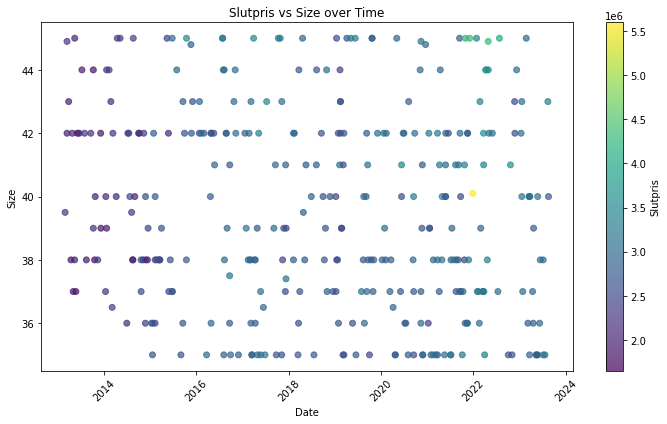

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by date
df = df.sort_values('date')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['date'], df['size'], c=df['slutpris'], cmap='viridis', marker='o', alpha=0.7)
plt.colorbar(label='Slutpris')
plt.xlabel('Date')
plt.ylabel('Size')
plt.title('Slutpris vs Size over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


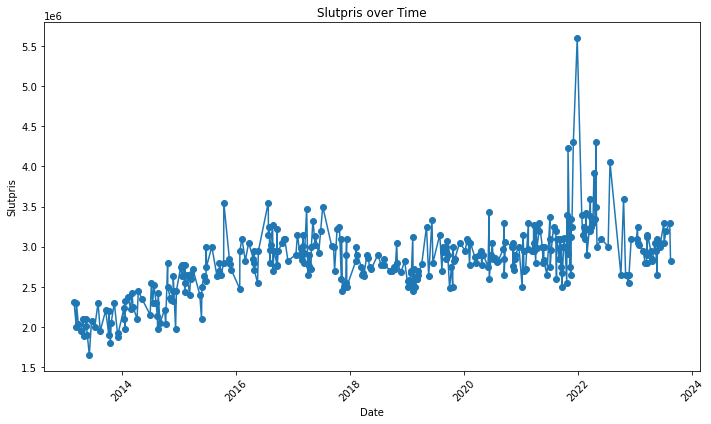

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by date
df = df.sort_values('date')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['slutpris'], marker='o')
plt.xlabel('Date')
plt.ylabel('Slutpris')
plt.title('Slutpris over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


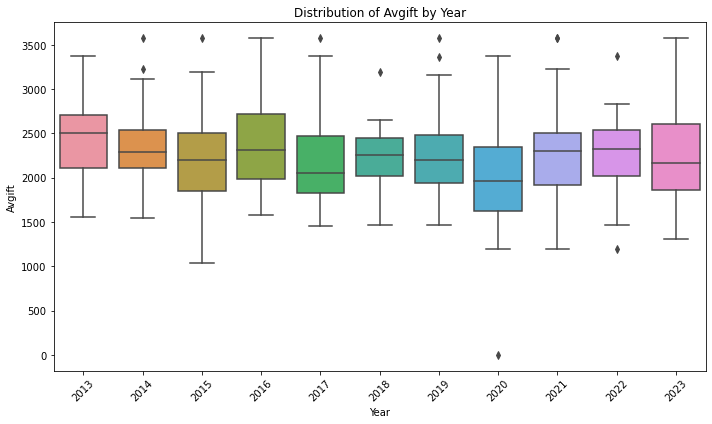

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the date
df['year'] = df['date'].dt.year

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='year', y='avgift')
plt.xlabel('Year')
plt.ylabel('Avgift')
plt.title('Distribution of Avgift by Year')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


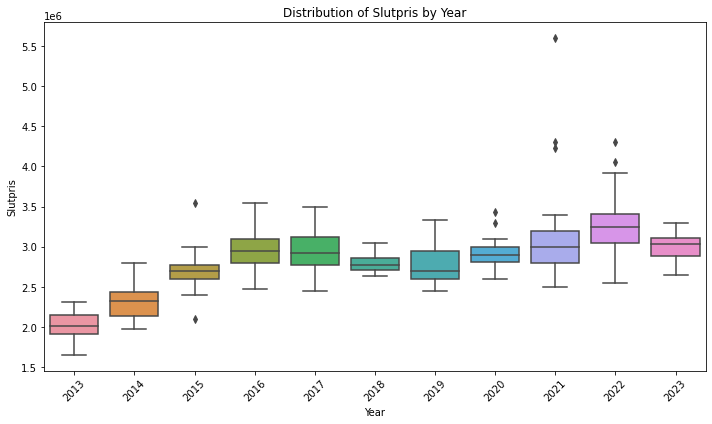

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the date
df['year'] = df['date'].dt.year

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='year', y='slutpris')
plt.xlabel('Year')
plt.ylabel('Slutpris')
plt.title('Distribution of Slutpris by Year')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


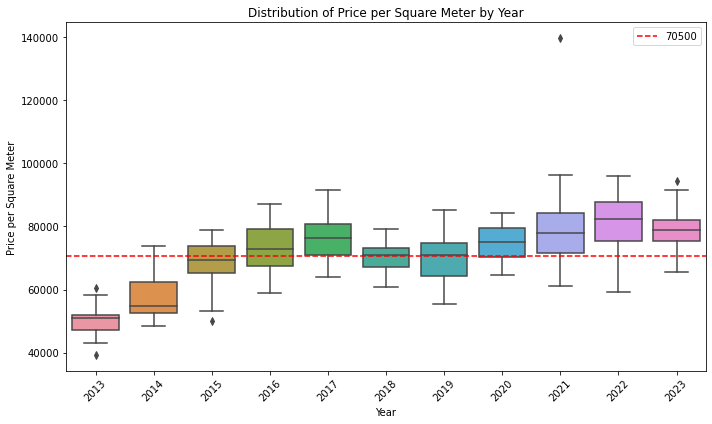

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the date
df['year'] = df['date'].dt.year

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='year', y='sqm_pris')
plt.axhline(y=70500, color='r', linestyle='--', label='70500')
plt.xlabel('Year')
plt.ylabel('Price per Square Meter')
plt.title('Distribution of Price per Square Meter by Year')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


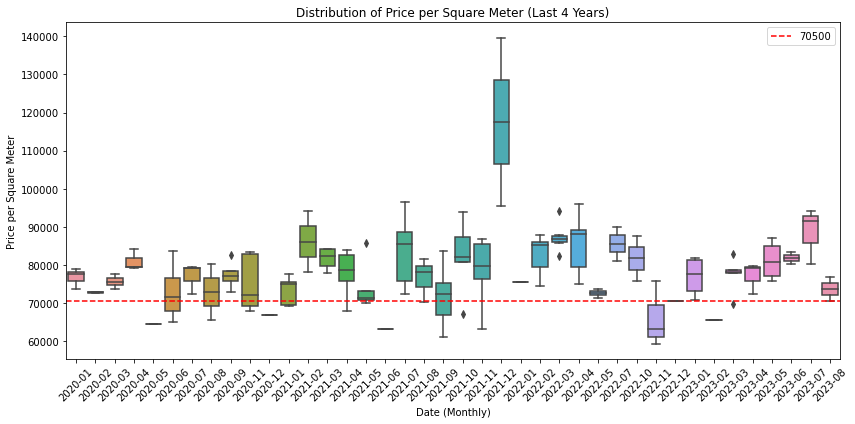

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the last four years
current_year = pd.Timestamp.today().year
last_four_years_df = df[df['date'].dt.year >= current_year - 3]

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(data=last_four_years_df, x=last_four_years_df['date'].dt.to_period('M'), y='sqm_pris')
plt.axhline(y=70500, color='r', linestyle='--', label='70500')
plt.xlabel('Date (Monthly)')
plt.ylabel('Price per Square Meter')
plt.title('Distribution of Price per Square Meter (Last 4 Years)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/2914647804.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_four_years_df['quarter'] = last_four_years_df['date'].dt.to_period('Q')


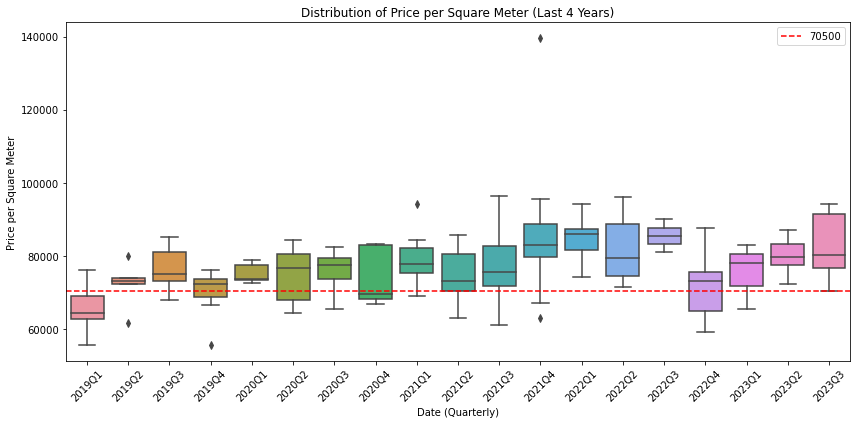

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the last four years
current_year = pd.Timestamp.today().year
last_four_years_df = df[df['date'].dt.year >= current_year - 4]

# Convert date to quarterly periods
last_four_years_df['quarter'] = last_four_years_df['date'].dt.to_period('Q')

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(data=last_four_years_df, x='quarter', y='sqm_pris')
plt.axhline(y=70500, color='r', linestyle='--', label='70500')
plt.xlabel('Date (Quarterly)')
plt.ylabel('Price per Square Meter')
plt.title('Distribution of Price per Square Meter (Last 4 Years)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/1579193872.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_four_years_df['quarter'] = last_four_years_df['date'].dt.to_period('Q')


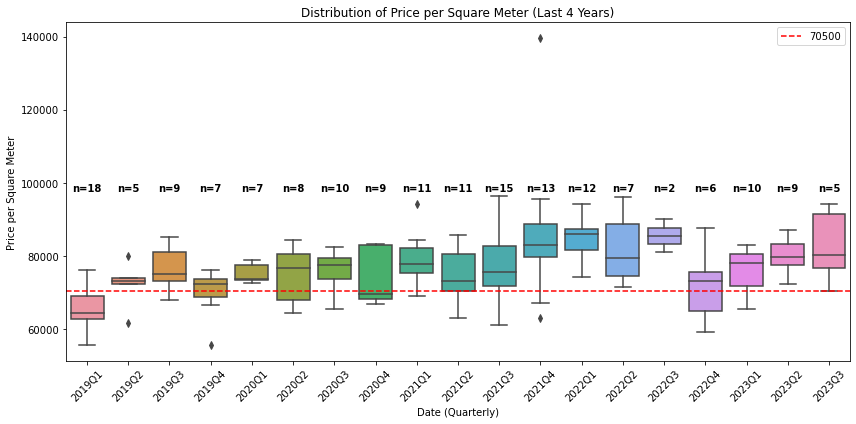

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the last four years
current_year = pd.Timestamp.today().year
last_four_years_df = df[df['date'].dt.year >= current_year - 4]

# Convert date to quarterly periods
last_four_years_df['quarter'] = last_four_years_df['date'].dt.to_period('Q')

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=last_four_years_df, x='quarter', y='sqm_pris')
plt.axhline(y=70500, color='r', linestyle='--', label='70500')
plt.xlabel('Date (Quarterly)')
plt.ylabel('Price per Square Meter')
plt.title('Distribution of Price per Square Meter (Last 4 Years)')
plt.xticks(rotation=45)

# Add data point counts above each boxplot (higher up)
data_counts = last_four_years_df.groupby('quarter').size()
for idx, count in enumerate(data_counts):
    ax.text(idx, 100000, f'n={count}', ha='center', va='top', fontweight='bold')

plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


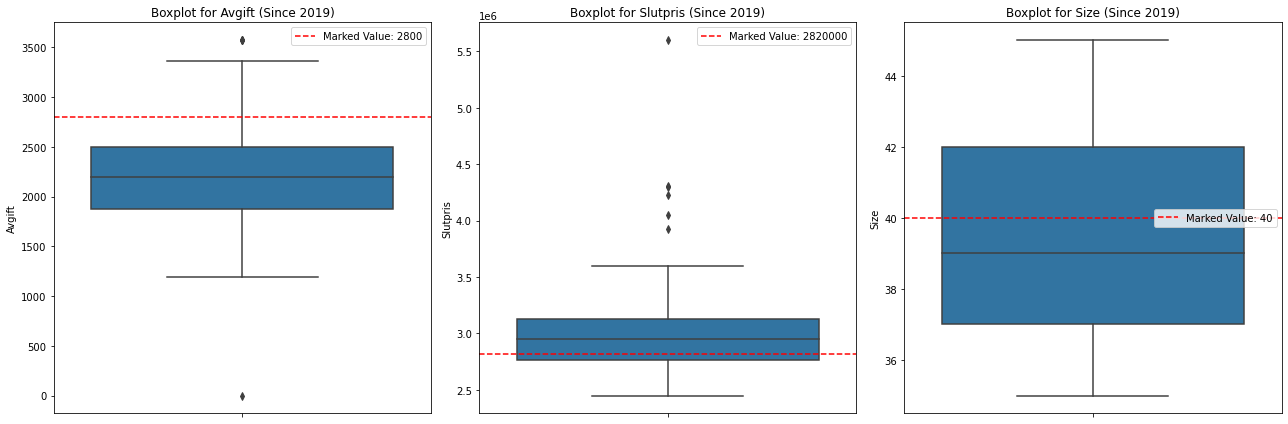

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the years since 2019
df_since_2019 = df[df['date'].dt.year >= 2019]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot for avgift
sns.boxplot(data=df_since_2019, y='avgift', ax=axes[0])
axes[0].axhline(y=2800, color='r', linestyle='--', label='Marked Value: 2800')
axes[0].set_ylabel('Avgift')
axes[0].set_title('Boxplot for Avgift (Since 2019)')
axes[0].legend()

# Boxplot for slutpris
sns.boxplot(data=df_since_2019, y='slutpris', ax=axes[1])
axes[1].axhline(y=2820000, color='r', linestyle='--', label='Marked Value: 2820000')
axes[1].set_ylabel('Slutpris')
axes[1].set_title('Boxplot for Slutpris (Since 2019)')
axes[1].legend()

# Boxplot for size
sns.boxplot(data=df_since_2019, y='size', ax=axes[2])
axes[2].axhline(y=40, color='r', linestyle='--', label='Marked Value: 40')
axes[2].set_ylabel('Size')
axes[2].set_title('Boxplot for Size (Since 2019)')
axes[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/3718270827.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_since_2019['quarter'] = df_since_2019['date'].dt.to_period('Q')


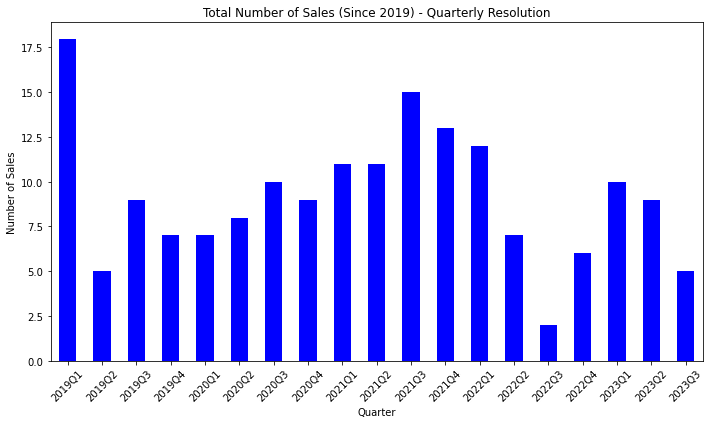

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the years since 2019
df_since_2019 = df[df['date'].dt.year >= 2019]

# Convert date to quarterly periods
df_since_2019['quarter'] = df_since_2019['date'].dt.to_period('Q')

# Group by quarter and count the number of sales
quarterly_sales = df_since_2019.groupby('quarter').size()

# Plotting
plt.figure(figsize=(10, 6))
quarterly_sales.plot(kind='bar', color='blue')
plt.xlabel('Quarter')
plt.ylabel('Number of Sales')
plt.title('Total Number of Sales (Since 2019) - Quarterly Resolution')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/3292066793.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_since_2019['quarter'] = df_since_2019['date'].dt.to_period('Q')


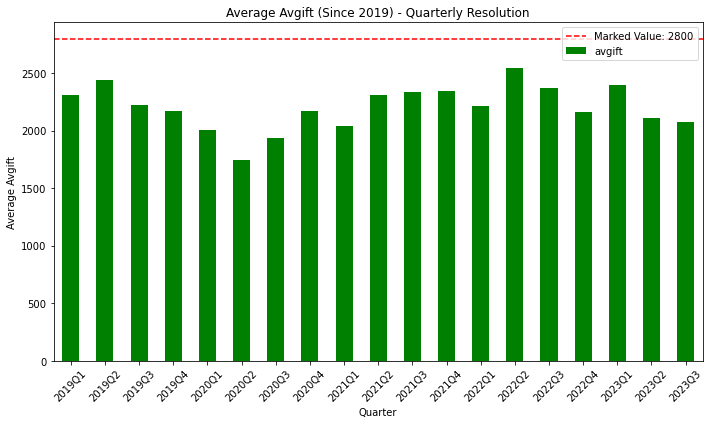

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the years since 2019
df_since_2019 = df[df['date'].dt.year >= 2019]

# Convert date to quarterly periods
df_since_2019['quarter'] = df_since_2019['date'].dt.to_period('Q')

# Group by quarter and calculate the average avgift
quarterly_avgift = df_since_2019.groupby('quarter')['avgift'].mean()

# Plotting
plt.figure(figsize=(10, 6))
quarterly_avgift.plot(kind='bar', color='green')
plt.axhline(y=2800, color='r', linestyle='--', label='Marked Value: 2800')
plt.xlabel('Quarter')
plt.ylabel('Average Avgift')
plt.title('Average Avgift (Since 2019) - Quarterly Resolution')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


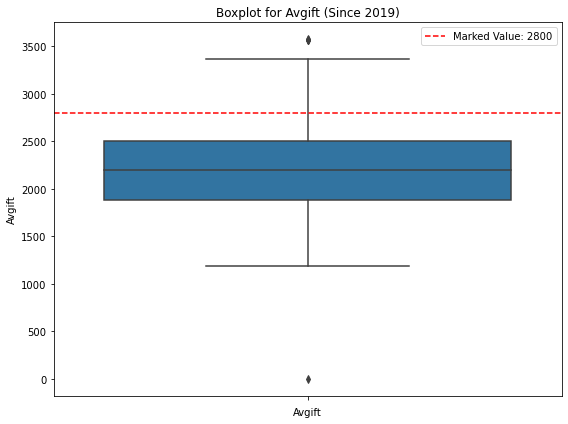

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the years since 2019
df_since_2019 = df[df['date'].dt.year >= 2019]

# Plotting
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df_since_2019, y='avgift')
plt.axhline(y=2800, color='r', linestyle='--', label='Marked Value: 2800')
plt.xlabel('Avgift')
plt.ylabel('Avgift')
plt.title('Boxplot for Avgift (Since 2019)')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/2213995022.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_since_2019['quarter'] = df_since_2019['date'].dt.to_period('Q')


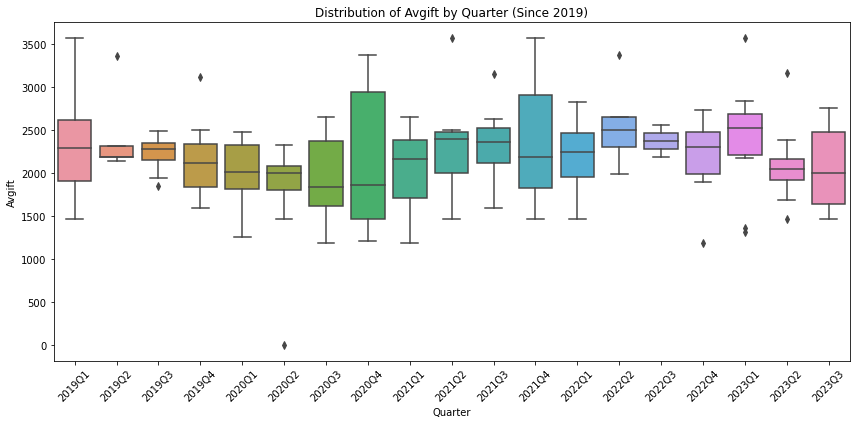

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the years since 2019
df_since_2019 = df[df['date'].dt.year >= 2019]

# Convert date to quarterly periods
df_since_2019['quarter'] = df_since_2019['date'].dt.to_period('Q')

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=df_since_2019, x='quarter', y='avgift')
plt.xlabel('Quarter')
plt.ylabel('Avgift')
plt.title('Distribution of Avgift by Quarter (Since 2019)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/n4/37zl64v150z2lq9vhml1q6lh0000gn/T/ipykernel_39660/1405414875.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_four_years_df['quarter'] = last_four_years_df['date'].dt.to_period('Q')


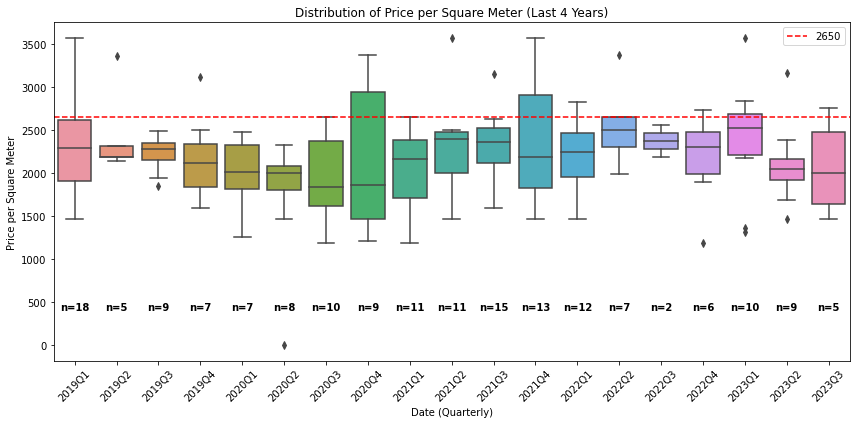

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame containing the house sales data
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data for the last four years
current_year = pd.Timestamp.today().year
last_four_years_df = df[df['date'].dt.year >= current_year - 4]

# Convert date to quarterly periods
last_four_years_df['quarter'] = last_four_years_df['date'].dt.to_period('Q')

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=last_four_years_df, x='quarter', y='avgift')
plt.axhline(y=2650, color='r', linestyle='--', label='2650')
plt.xlabel('Date (Quarterly)')
plt.ylabel('Price per Square Meter')
plt.title('Distribution of Price per Square Meter (Last 4 Years)')
plt.xticks(rotation=45)

# Add data point counts above each boxplot (higher up)
data_counts = last_four_years_df.groupby('quarter').size()
for idx, count in enumerate(data_counts):
    ax.text(idx, 500, f'n={count}', ha='center', va='top', fontweight='bold')

plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
